In [1]:
# Just KNN implementation for Learning Purposes
# Based on Stanford Computer Vision Course

import os

import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as la

import xml.etree.ElementTree as etree

from PIL import Image

from tqdm import tqdm

In [2]:
class KNearestNeighbor(object):

    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):

        dists = self.compute_distances(X)

        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        print('Computing Distances...')
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        X_sum_sqrs = np.sum(np.square(X), axis=1)
        X_train_sum_sqrs = np.sum(np.square(self.X_train), axis=1)
        mat_mult = np.dot(X, np.transpose(self.X_train))
        dists += X_sum_sqrs[:, np.newaxis] + X_train_sum_sqrs[np.newaxis, :] - (2 * mat_mult )
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in tqdm(range(num_test), desc='Predicting labels'):
            k_nearest = np.argsort(dists[i])[:k]
            closest_y = self.y_train[k_nearest]
            popular_votes = np.bincount(closest_y)
            y_pred[i] = np.argmax(popular_votes)

        return y_pred

In [5]:
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    fname = z.find('./filename').text
    dicts = [{obj.find('name').text: [int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))]}
             for obj in objects]
    return {'size': size, 'filename': fname, 'objects': dicts}

def run_knn(X_train, y_train, X_validation, y_validation, k):
    classifer = KNearestNeighbor()
    classifier.train(X_train, y_train)

    print("Evaluating Validation Data")
    y_pred_val = classifier.predict(X_validation, k=k)
    num_correct = np.sum(y_pred_val == y_validation)
    accuracy_val = float(num_correct)/len(y_validation)

    print("Evaluating Training Data")
    y_pred_train = classifier.predict(X_train, k=k)
    num_correct = np.sum(y_pred_train == y_train)
    accuracy_train = float(num_correct)/len(y_train)

    return {"accuracy_val": accuracy_val, "accuracy_train": accuracy_train}

def read_image(img_path):

    img = Image.open(img_path)

    img = img.convert('L')

    img = img.resize((224, 224))

    img_array = np.array(img) / 255.0

    return img_array

def read_images(images_folder='/kaggle/input/dog-and-cat-detection/images'):
  X = []
  image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

  for img_file in image_files:
      img_path = os.path.join(images_folder, img_file)

      img_array = read_image(img_path)

      X.append(img_array)
  return np.array(X)

def preprocess_images(image_paths):
    images = [image.load_img(img_path, target_size=(224, 224)) for img_path in image_paths]
    images = [image.img_to_array(img) for img in images]
    images = np.array([preprocess_input(img) for img in images])
    return images

def split_data(X, y, split_ratio=0.8):
    global num_samples
    global num_training
    global num_test

    num_samples = len(X)
    num_training = round(split_ratio * num_samples)
    num_test = num_samples - num_training

    X_train = np.array(X[:num_training])
    y_train = np.array(y[:num_training])

    X_test = np.array(X[num_training:])
    y_test = np.array(y[num_training:])

    return X_train, y_train, X_test, y_test



In [8]:
%%time

X = read_images()

X.shape

CPU times: user 34.2 s, sys: 2.32 s, total: 36.5 s
Wall time: 39.1 s


(3686, 224, 224)

In [9]:
%%time

y = []

filters = ['dog', 'cat']

idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

ANNOTATION_DIR = '/kaggle/input/dog-and-cat-detection/annotations'
for filename in sorted(os.listdir(ANNOTATION_DIR)):
    annotation = extract_xml_annotation(os.path.join(ANNOTATION_DIR, filename))

    new_objects = []
    for obj in annotation['objects']:
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)
    y.append(labels2idx[list(new_objects[0].keys())[0]])

y = np.array(y)

CPU times: user 551 ms, sys: 160 ms, total: 711 ms
Wall time: 2.29 s


In [14]:
print(f'Number of images: {len(X)}.')
print(f'Number of images with annotations: {len(y)}.')
print(f'Example contents of one annotation: {y[0], (idx2labels[y[0]])}')
print(f'Correspondence between indices and labels: {idx2labels}')

Number of images: 3686.
Number of images with annotations: 3686.
Example contents of one annotation: (1, 'cat')
Correspondence between indices and labels: {0: 'dog', 1: 'cat'}


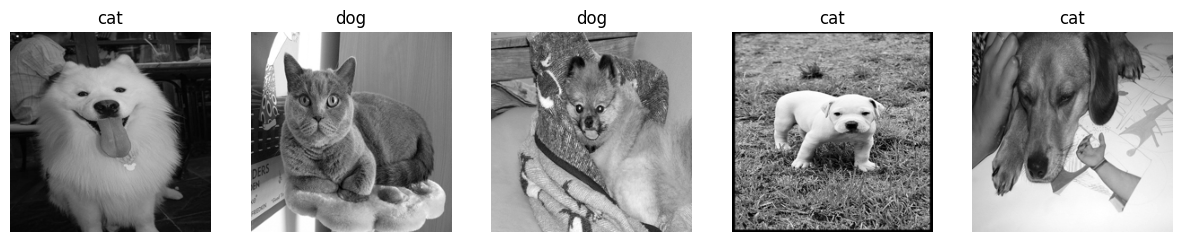

In [15]:
num_images_to_display = 5

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'{idx2labels[y[i]]}')

plt.show()

In [16]:
X_train, y_train, X_test, y_test = split_data(X, y, split_ratio=0.8)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2949, 224, 224), (2949,), (737, 224, 224), (737,))

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

X_train.shape, X_test.shape

((2949, 50176), (737, 50176))